In [1]:
import numpy as np, os
import matplotlib as mpl
%matplotlib notebook

In [2]:
from matplotlib import pyplot as plt

In [3]:
workdir = '_tmp.explore-random-sampling-big-Qspace-box'
!mkdir -p {workdir}
%cd {workdir}

/home/lj7/dv/mcvine/phonon/tests/phonon/_tmp.explore-random-sampling-big-Qspace-box


# Experiment

plot z in (0, 3)


<IPython.core.display.Javascript object>


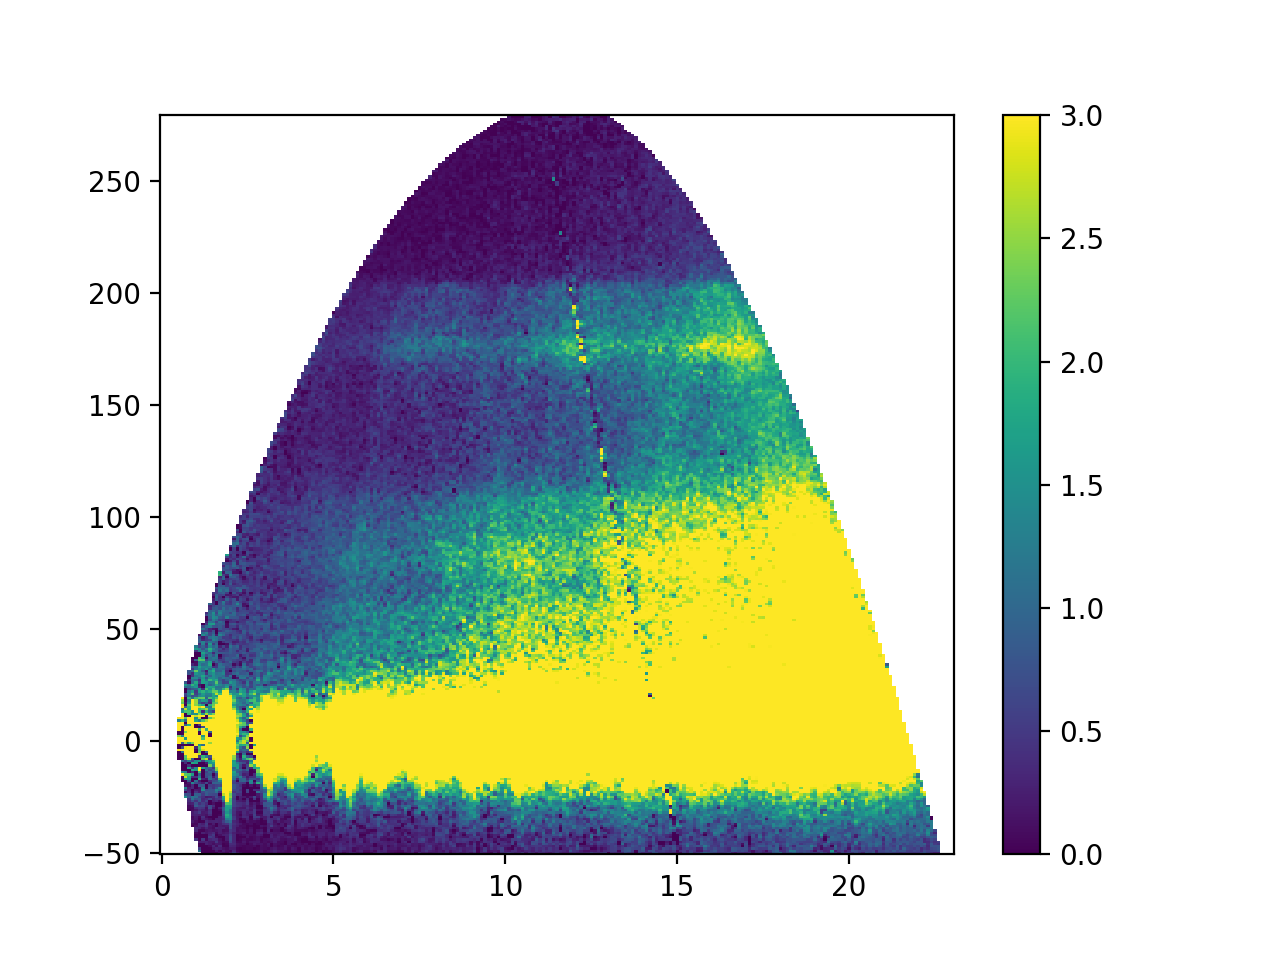

In [79]:
exp = hh.load('/SNS/users/lj7/simulations/ARCS/graphite/getdos-non-Rad-300meV/iqe-interped.h5')
H.plot(exp[(), (-50, None)], min=0, max=3)

# Calculation

In [4]:
from mcvine.phonon.from_phonopy import call_phonopy

In [5]:
supercell = 6,6,1
sc_mat = np.diag(supercell)

In [6]:
graphite_datadir = os.path.abspath('../../data/graphite/')

In [7]:
from phonopy import file_IO
force_constants=file_IO.parse_FORCE_CONSTANTS(os.path.join(graphite_datadir, 'FORCE_CONSTANTS'))

In [8]:
poscar = os.path.join(graphite_datadir, 'POSCAR')

In [9]:
species = ['C']

In [10]:
qpoints = [[0.,0.,0.], [1,0,0], [0,1,0], [0,0,1], [1,1,0], [1,0,1], [0, 1,1], [1,1,1]]

In [11]:
qs, freqs, pols = call_phonopy.onGrid(
    species, qpoints, sc_mat, 
    force_constants = force_constants,
    poscar = poscar,
    freq2omega=1
)

In [12]:
freqs.shape

(8, 12)

In [13]:
freqs[0]

array([  3.34225831e-02,   3.34225831e-02,   9.28652901e-02,
         1.52100901e+00,   1.52100901e+00,   2.61040097e+00,
         2.63887591e+01,   2.65558347e+01,   4.76904068e+01,
         4.76904068e+01,   4.78045328e+01,   4.78045328e+01])

In [14]:
pols.shape

(8, 12, 4, 3)

In [15]:
norms = np.linalg.norm(pols, axis=-1)

In [16]:
pols/=norms[:, :, :, np.newaxis]

In [17]:
pols[0][2]

array([[ -1.38736765e-11+0.j,   8.71603397e-12+0.j,  -1.00000000e+00+0.j],
       [ -1.37925833e-11+0.j,   8.75866422e-12+0.j,  -1.00000000e+00+0.j],
       [ -1.38740305e-11+0.j,   8.71665564e-12+0.j,  -1.00000000e+00+0.j],
       [ -1.37932231e-11+0.j,   8.75860894e-12+0.j,  -1.00000000e+00+0.j]])

In [18]:
cat {poscar}

C
    1.0
       2.44618916393 0.00000000000   0.00000000000           
      -1.22309458197 2.11846195843   0.00000000000
       0.00000000000   0.00000000000 6.65422904762 
  4
Direct
        0.00000000 0.00000000 0.25000000
        0.00000000 0.00000000 0.75000000
        0.33333333 0.66666667 0.25000000
        0.66666667 0.33333333 0.75000000


# random Q points

In [20]:
Q_bins = np.arange(0,22, 0.1)
E_bins = np.arange(0,250, 1.)
bins = Q_bins, E_bins
# max Q of requested Q axis                                                                                                                                                                                                                                                                                     
max_Q = Q_bins[-1]

In [302]:
%%time
N = int(1e7)
N = int(1e6)
# we should use random distribution fo Qmag^3. HOwever, when we do that there are too 
# few points for low Q. 
# so instead we randomly choose Qmag, and change weight factor
# Qmag_p3 = np.random.rand(N)*max_Q**3
# Qmag = Qmag_p3**(1./3)
Qmag = np.random.rand(N) * max_Q
cos_theta = np.random.rand(N)*2-1  # -1 -- 1
phi = np.random.rand(N) * 2 * np.pi
sin_theta = np.sqrt(1-cos_theta*cos_theta)
sin_phi = np.sin(phi); cos_phi = np.cos(phi)
Qx = Qmag*sin_theta*cos_phi
Qy = Qmag*sin_theta*sin_phi
Qz = Qmag*cos_theta
Qpoints = np.array([Qx,Qy,Qz]).T

CPU times: user 188 ms, sys: 16 ms, total: 204 ms
Wall time: 202 ms


# Cartesian to hkl

In [23]:
from mcvine.phonon import from_phonopy

In [24]:
from_phonopy.make_crystal_xyz('graphite.xyz', species, poscar)

In [25]:
from sampleassembly.crystal.ioutils import xyzfile2unitcell

In [26]:
uc = xyzfile2unitcell('graphite.xyz')

rows are reciprocal lattice vectors

In [35]:
Q_basis = np.linalg.inv(uc.lattice.base).T*np.pi*2

In [37]:
np.allclose(np.dot(uc.lattice.base, Q_basis.T), np.eye(3)*2*np.pi)

True

```
Q = h b1 + k b2 + l b3
h = (Q . a1) / 2pi
...
```

In [331]:
hkls = np.dot(Qpoints, uc.lattice.base.T)/(2*np.pi)

In [332]:
Qpoints[0], hkls[0]

(array([-5.73154432,  2.8827292 , -9.45100632]),
 array([ -2.23142258,   2.08766291, -10.00912081]))

In [333]:
hkls.shape

(1000000, 3)

about an hour for 1e7 at heetuu

In [334]:
%%time
qs, freqs, pols = call_phonopy.onGrid(
    ['C'], hkls, sc_mat, 
    force_constants = force_constants,
    poscar = os.path.join(graphite_datadir, 'POSCAR'),
    freq2omega=1
)

CPU times: user 31min 21s, sys: 49min 8s, total: 1h 20min 30s
Wall time: 6min 45s


In [335]:
good = freqs > 0

In [336]:
# omega2 = freqs**2 * 1e24 * (2*np.pi)**2

In [337]:
omega = freqs*1e12*2*np.pi

In [338]:
nq, nbr, natoms, three = pols.shape

In [339]:
assert three is 3

In [340]:
from phonopy.interface import vasp
atoms = vasp.read_vasp(poscar, species)
positions = atoms.get_scaled_positions()

In [341]:
%%time
for iatom in range(natoms):
    qdotr = np.dot(qs, positions[iatom]) * 2 * np.pi
    phase = np.exp(-1j * qdotr)
    pols[:, :, iatom, :] *= phase[:, np.newaxis, np.newaxis]
    norms = np.linalg.norm(pols, axis=-1)
    pols/=norms[:, :, :, np.newaxis]
    continue

CPU times: user 15.4 s, sys: 12.8 s, total: 28.2 s
Wall time: 15.8 s


# Compute

Refs
* http://mcvine.github.io/1.3.1/KernelImplementation.html?#coherent-inelastic-phonon-kernel-for-powder-sample
* https://github.com/mcvine/mcvine/blob/c89c30602d3c538903876ab3bce58b03af0581e4/packages/mccomponents/lib/kernels/sample/phonon/CoherentInelastic_PolyXtal.cc

For each "event", we need to calculate
$$
\sigma_{\textbf{Q}} =
\frac{\sigma_{coh}}{4\pi}
\frac{k_f}{k_i}
\frac{\left( 2\pi \right)^3}{v_0}
e^{-2W}
\frac{\hbar^2 ({\textbf Q}\cdot {\textbf e})^2}{2M \hbar\omega}
\langle n + 1 \rangle
\frac{1}{2 k_i k_f Q}
$$

* this quantity has the unit of a cross section
* ignore $\frac{k_f}{k_i}$ because correction reduction for exp data removes that
* The non-trivial part is 

$$
\frac{ \sigma_{coh} }{4\pi}
e^{-2W}
\frac{\hbar^2 ({\textbf Q}\cdot {\textbf e})^2}{2M \hbar\omega}
$$

Actually the more precise formula for this expression is

$$
\frac{1}{2\hbar\omega}
\left | 
\sum_j \frac{b_j}{\sqrt{M_j}} \exp(-W_j) \exp(i {\textbf Q}\cdot {\textbf d_j}) \; \hbar({\textbf Q}\cdot {\textbf e}_j)
\right |^2
$$

where 
$$
W_j = \frac{1}{4M_j N} \sum_s\frac{\hbar^2
 \left |{\textbf Q}\cdot{\textbf e}_{js} \right |^2}{\hbar\omega_s} \langle 2n_s + 1 \rangle
$$
* for this calculation we use the second formula and let $b=1$
* We will only compute the non-trivial part below. The trivial parts will be added as corrections. Actually for the non-trivial part we don't include Debye Waller factor. It will also be added as a correction

In [83]:
mass = 12

In [210]:
from mccomponents.sample.idf import units

In [364]:
omega *= units.hertz2mev

In [365]:
omega[0]

array([   9.82440083,   16.80851468,   52.92642289,   52.96674635,
         79.60401031,   80.0921949 ,  104.86018768,  105.34461481,
        189.11317479,  189.37500963,  202.27750085,  202.78319136])

In [343]:
omega.shape

(1000000, 12)

In [344]:
pols.shape

(1000000, 12, 4, 3)

In [345]:
nbranches = nbr

In [346]:
import tqdm

In [347]:
Q_mag = np.linalg.norm(Qpoints, axis=-1)

In [366]:
%%time
I = 0
for ibr in tqdm.tqdm(range(nbranches)):
    good1 = good[:, ibr]
    Q_mag_good = Q_mag[good1]
    omega_good = omega[good1, ibr]
    Q_cart = Qpoints[good1, :]
    #
    exp_Q_dot_d = np.exp(1j * np.dot(Q_cart, positions.T)) # nQ, natoms 
    pols1 = pols[good1, ibr, :, :] # nQ, natoms, 3   
    Q_dot_pol = np.sum(np.transpose(pols1, (1,0,2)) * Q_cart, axis=-1).T # nQ, natoms
    # 
    F = np.sum(exp_Q_dot_d * Q_dot_pol, axis=-1) # nQ      
    M = np.abs(F)**2 / omega_good * Q_mag_good**2 * (3./max_Q**2)# nQ  
    I1, Qbb, Ebb = np.histogram2d(Q_mag_good, omega_good, bins=bins, weights=M)
    I = I + I1
    continue

100%|██████████| 12/12 [00:10<00:00,  1.17it/s]

CPU times: user 9.57 s, sys: 732 ms, total: 10.3 s
Wall time: 10.3 s


In [349]:
from mcni.utils import conversion

In [368]:
I *= 1./mass * conversion.k2e(1.)

In [351]:
import histogram as H, histogram.hdf as hh

In [352]:
Q = (Qbb[1:] + Qbb[:-1])/2

In [370]:
from multiphonon.sqe import plot as plotsqe

In [377]:
IQEhist = H.histogram(
    'IQE',
    (H.axis('Q', boundaries=Qbb, unit='1./angstrom'),
     H.axis('E', boundaries=Ebb, unit='meV')),
    data=I)

In [378]:
%matplotlib notebook

<IPython.core.display.Javascript object>


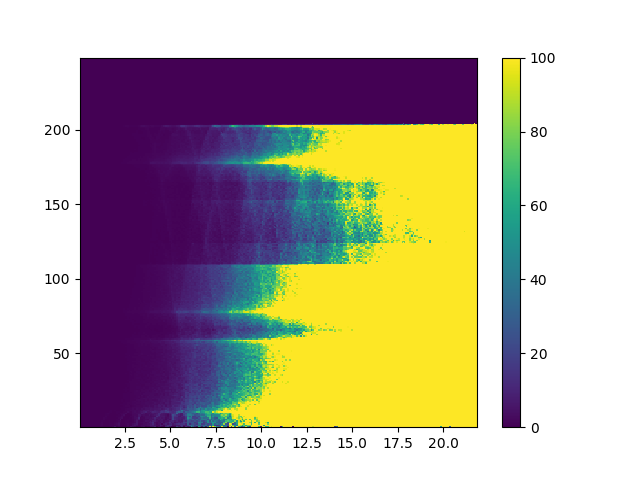

In [380]:
plt.figure()
plotsqe(IQEhist)
plt.clim(0, 100)

In [381]:
IQ = IQEhist[(), (150, 220)].sum('E')

In [382]:
%matplotlib notebook

<IPython.core.display.Javascript object>


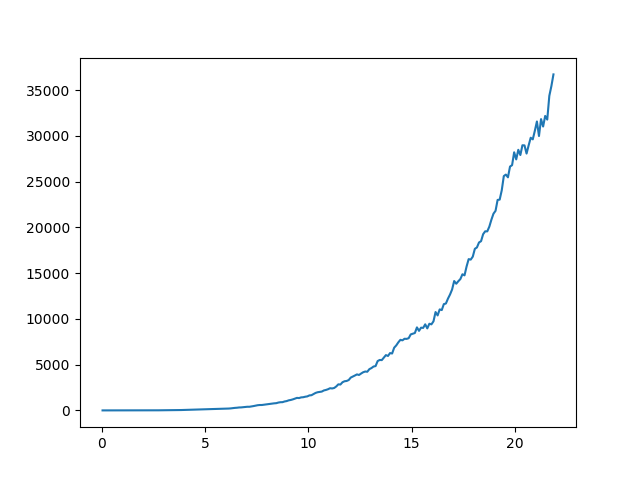

In [383]:
plt.figure()
plt.plot(IQ.Q, IQ.I)

approx $Q^4$ behavior. correct. because $Q^2$ from $|e \cdot Q|^2$, and another $Q^2$ from integration over spherical coordinates  ($Q^2 dQ \sin \theta d \theta d\phi$)

# Correction 1

$$
\frac{\left( 2\pi \right)^3}{v_0}
\langle n + 1 \rangle
\frac{1}{2 k_i k_f Q}
$$

$$
\langle n + 1 \rangle = \frac{1}{2} \left \{ \coth(\frac{1}{2}\hbar\omega \beta) + 1 \right \}
$$

In [92]:
Ei = 300.

In [93]:
ki = conversion.e2k(300.)
print ki

12.0324199927


In [95]:
E = (Ebb[1:] + Ebb[:-1])/2

In [96]:
Ef = Ei - E
kf = conversion.e2k(Ef)

In [101]:
v0 = uc.lattice.volume

In [103]:
T=300.
from multiphonon.forward.phonon import kelvin2mev
beta = 1./(T*kelvin2mev)

In [104]:
np.tanh?

In [106]:
thermal_factor = 1./2 * (1./np.tanh(E/2*beta) + 1)

In [127]:
%matplotlib notebook

In [111]:
correction_E = thermal_factor * (2*np.pi)**3/v0 / (2*ki*kf)

<IPython.core.display.Javascript object>


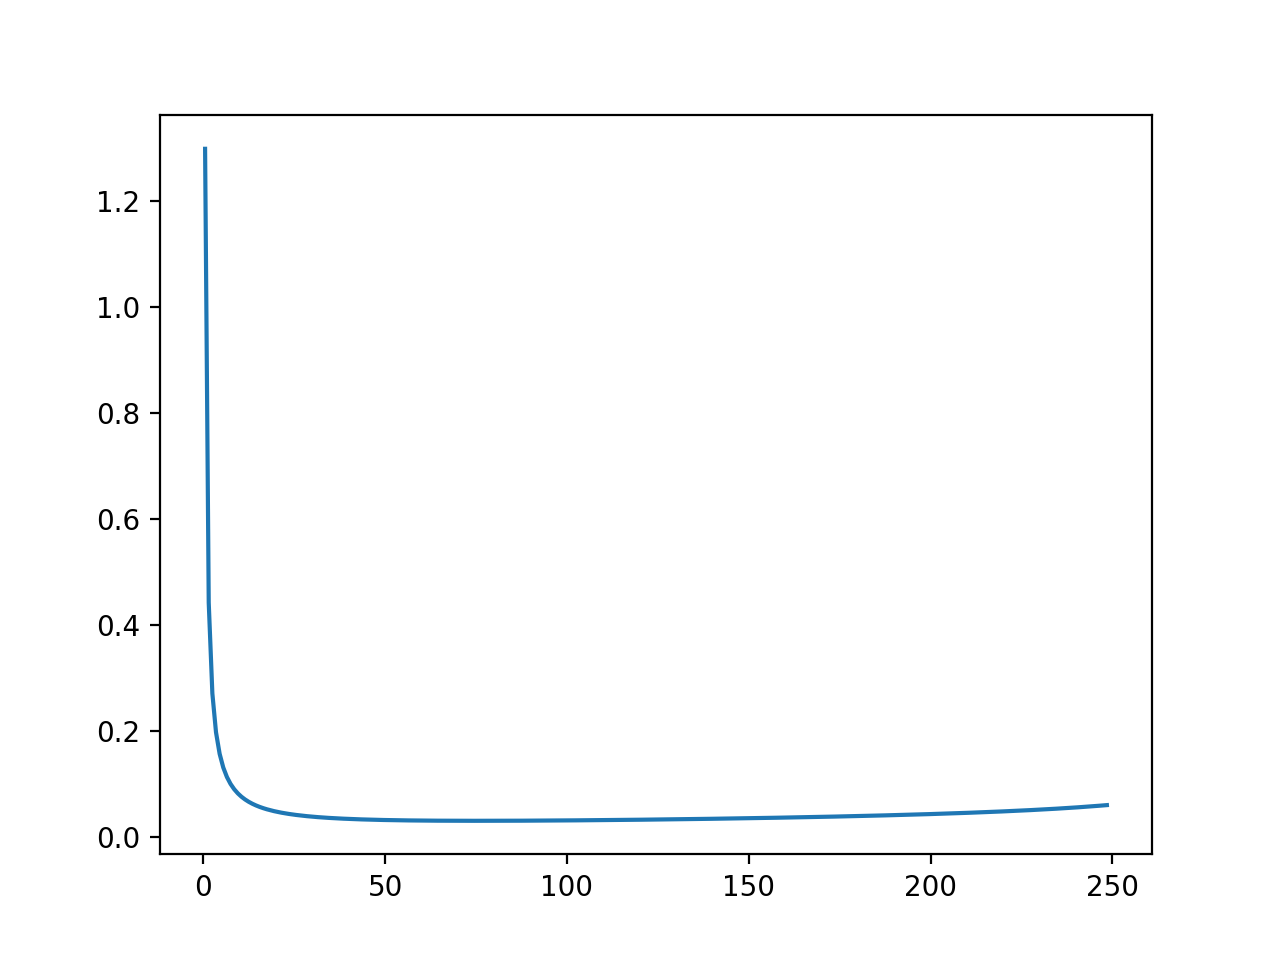

In [122]:
plt.figure()
plt.plot(E, correction_E)

In [113]:
correction_Q = 1./Q

In [384]:
correction = np.outer(correction_Q, correction_E)

In [385]:
IQEhist2 = IQEhist.copy()
IQEhist2.I*=correction

In [386]:
%matplotlib notebook

<IPython.core.display.Javascript object>


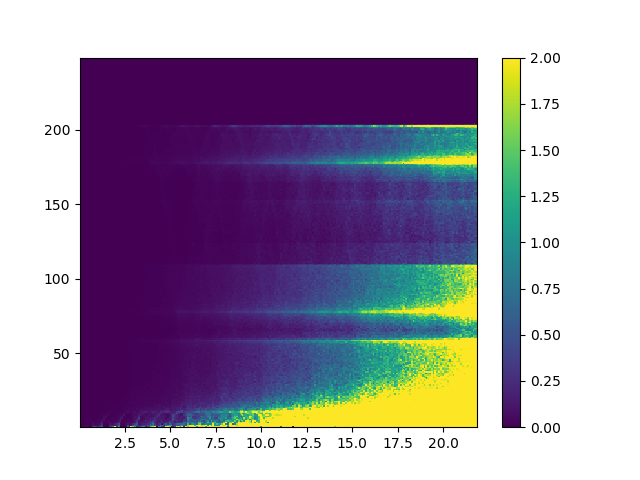

In [389]:
plt.figure()
plotsqe(IQEhist2)
plt.clim(0, 2)

# Correction 2 - DW
If we directly use the DFT DOS, the DW is not quite right. Probably because the low E portion is not quite right. Iyad sent me a new DFT result, which probably will correct this.

DFT result

In [129]:
e, g = np.loadtxt('/SNS/users/lj7/simulations/samples/graphite/dispersions/dos/dos_meV.dat').T

In [130]:
g = np.interp(Ebb, e, g)

In [132]:
%matplotlib notebook

<IPython.core.display.Javascript object>


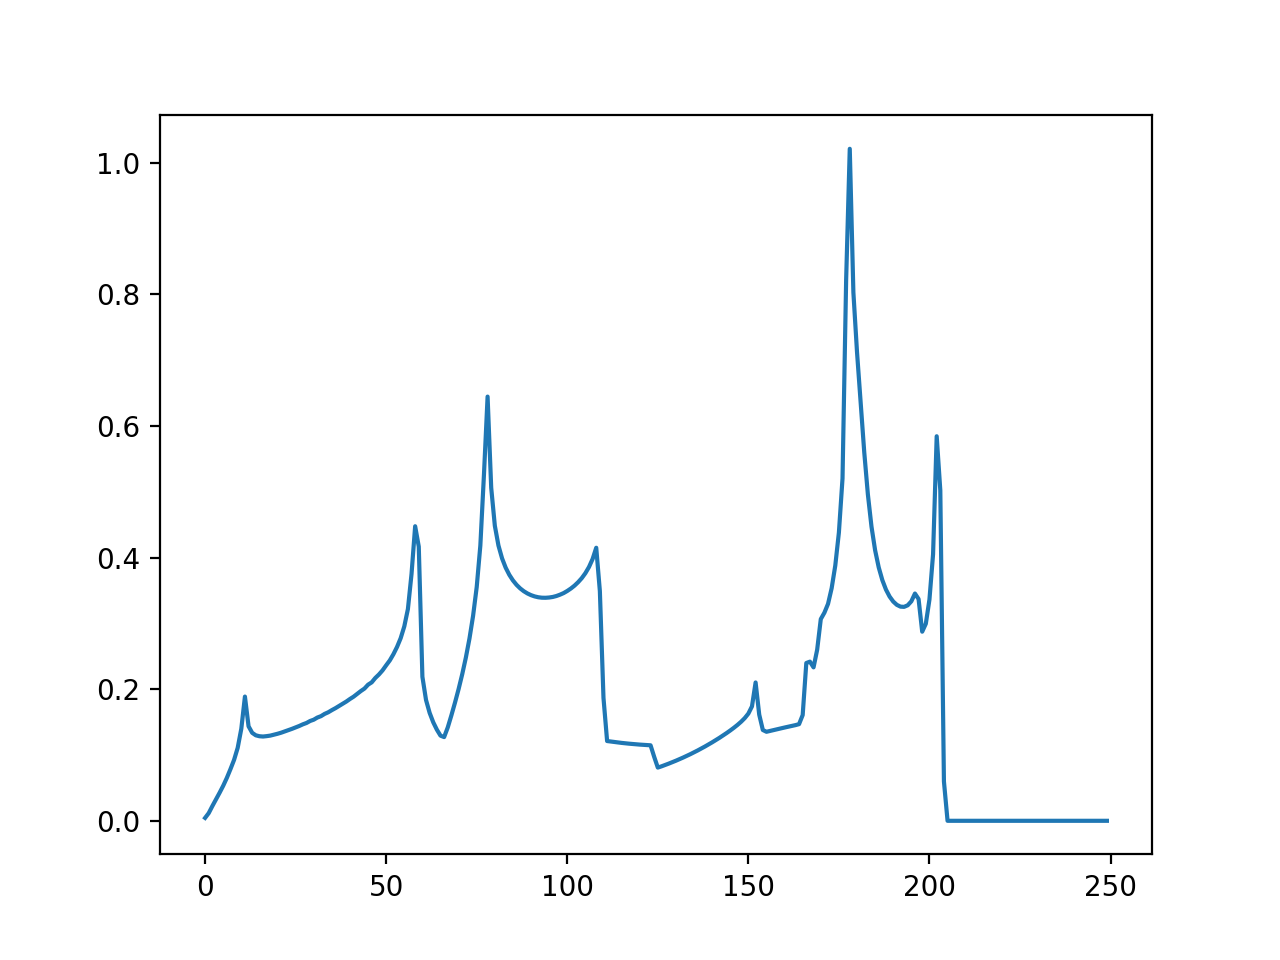

In [133]:
plt.figure()
plt.plot(Ebb, g)

In [134]:
import multiphonon

In [135]:
from multiphonon.forward import phonon

In [137]:
!head -n 10 /SNS/ARCS/IPTS-15398/shared/mantidred/non-radC/non-radC_130p00_summary.txt

-----------VANADIUM CALIBRATION AND MASKING-----------
Calibration loaded from /SNS/lustre/ARCS/IPTS-15398/shared/mantidred/van74333.nxs

-----------DATA REDUCTION-----------------------------
Loaded data run from /SNS/ARCS/IPTS-15398/0/79933/NeXus/ARCS_79933_event.nxs
Added data run from /SNS/ARCS/IPTS-15398/0/79934/NeXus/ARCS_79934_event.nxs
Added data run from /SNS/ARCS/IPTS-15398/0/79939/NeXus/ARCS_79939_event.nxs
Added data run from /SNS/ARCS/IPTS-15398/0/79940/NeXus/ARCS_79940_event.nxs
Added data run from /SNS/ARCS/IPTS-15398/0/79945/NeXus/ARCS_79945_event.nxs
Added data run from /SNS/ARCS/IPTS-15398/0/79946/NeXus/ARCS_79946_event.nxs


In [138]:
!head -n 20 /SNS/ARCS/IPTS-15398/0/79933/preNeXus/ARCS_79933_runinfo.xml

<?xml version="1.0"?>
<RunInfo instrument="ARCS" runnumber="79933" experiment="0" version="4.3" xmlns="http://neutrons.ornl.gov/SNS/DAS/runinfo_v4_3">
<DateTime>
	<StartTime> 2016-05-03T21:22:06-05:00 </StartTime>
	<StopTime> 2016-05-03T21:54:45-05:00 </StopTime>
	<LastUpdate> 2016-05-03T21:54:45-05:00 </LastUpdate>
</DateTime>
<OperationalInfo>
		<AcceleratorPulses> 117535 </AcceleratorPulses>
		<PCurrent units="pC"> 2.000864e+012 </PCurrent>
		<TotalVetos>0</TotalVetos></OperationalInfo>
<SampleInfo Name="REactort Grade Graphite" Identifier="29695">
	<Nature> NONE </Nature>
</SampleInfo>
<GeneralInfo>
	<Title>79933 Graphite_not-irradiated-G2w01 300K Ch2 130meV 600Hz T0 90Hz </Title>
	<Notes>no notes</Notes>
	<SpecialDesignation></SpecialDesignation>
	<ScriptID>none</ScriptID>
	<RunStatus>Stopped</RunStatus>


In [139]:
DW2 = phonon.DWExp(Q, M=12, E=Ebb,g=g/np.sum(g), beta=beta, dE=Ebb[1]-Ebb[0])

In [140]:
%matplotlib notebook

<IPython.core.display.Javascript object>


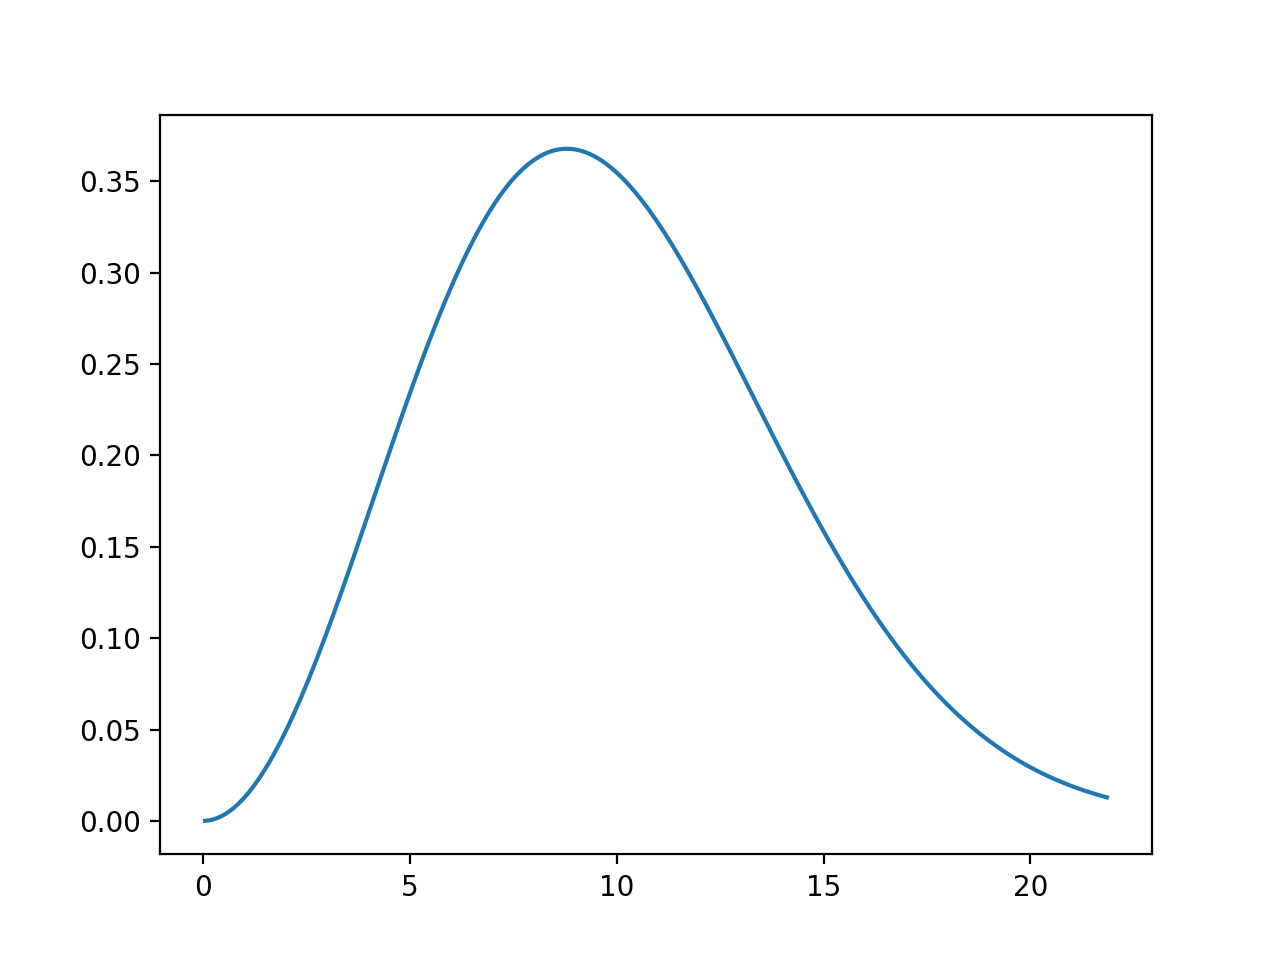

In [141]:
plt.figure()
plt.plot(Q, DW2*np.exp(-DW2))

experimental result

In [142]:
dos = hh.load('/SNS/users/lj7/simulations/ARCS/graphite/getdos-non-Rad-multiEi-30meV/work/final-dos.h5')

In [143]:
e = dos.E
g = dos.I

<IPython.core.display.Javascript object>


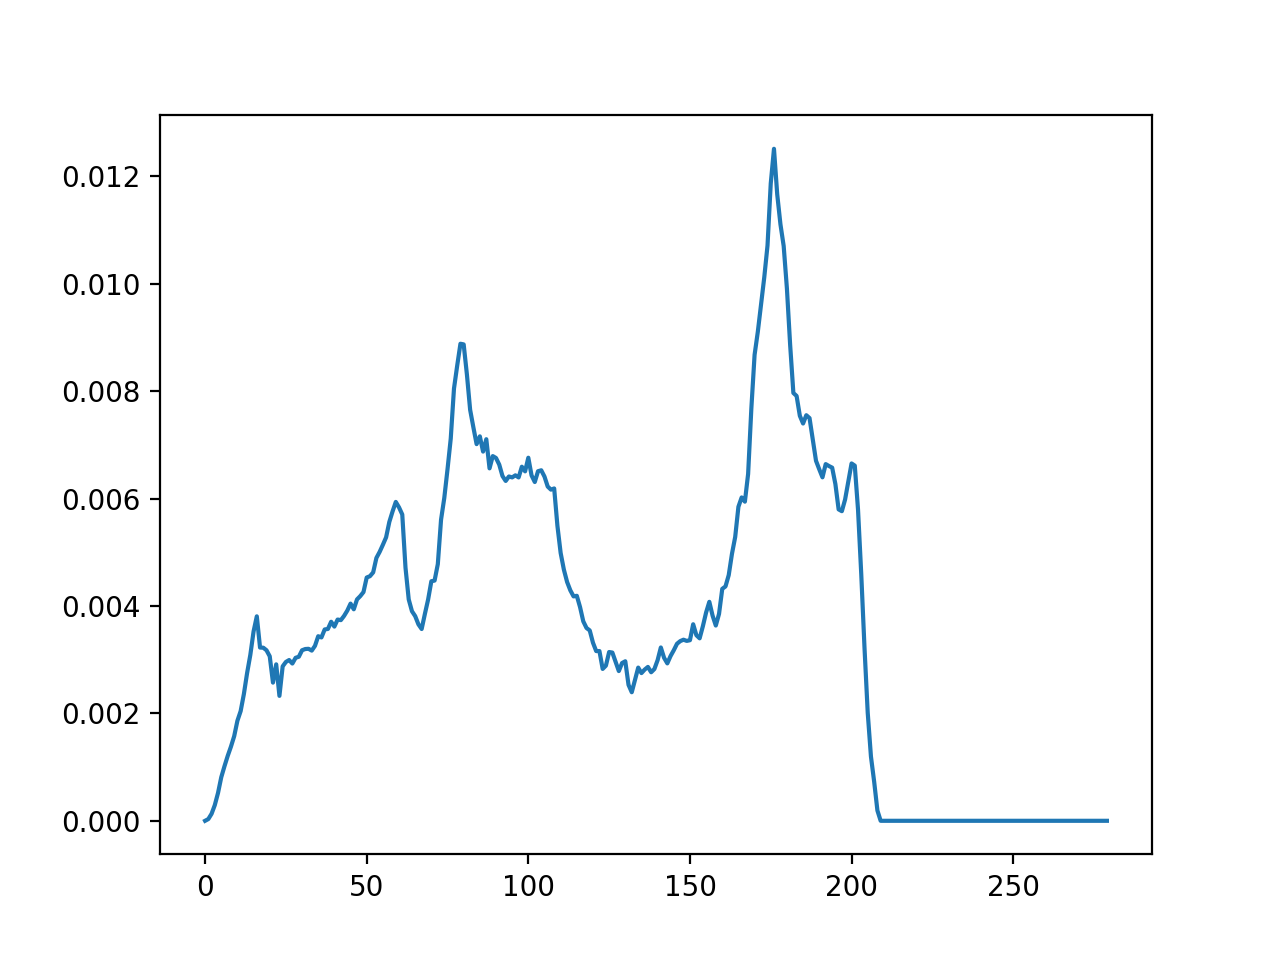

In [144]:
plt.figure()
plt.plot(e,g)

In [145]:
DW2 = phonon.DWExp(Q, M=12, E=e,g=g/np.sum(g), beta=beta, dE=e[1]-e[0])

<IPython.core.display.Javascript object>


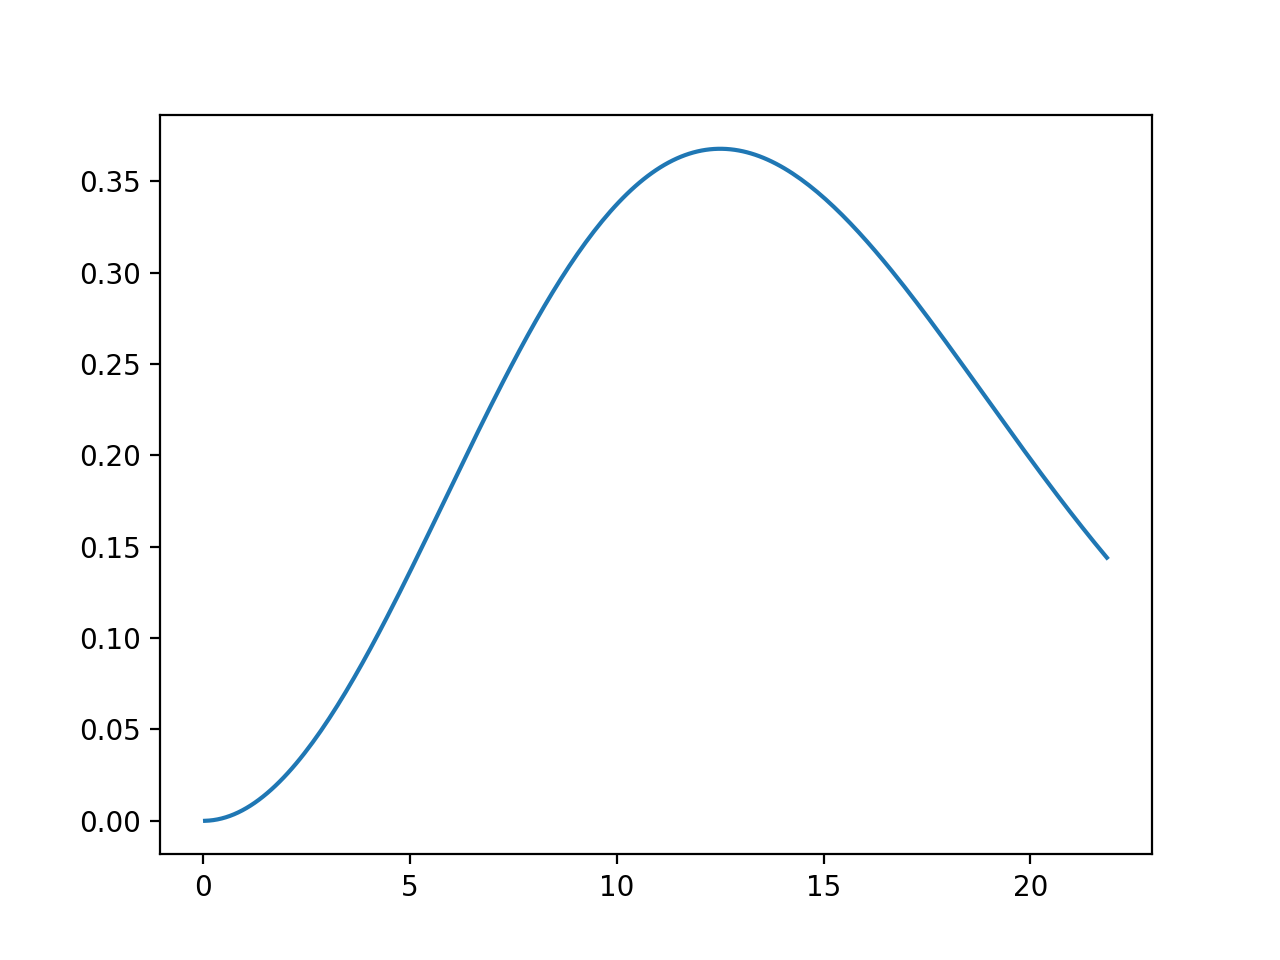

In [146]:
plt.figure()
plt.plot(Q, DW2*np.exp(-DW2))

Apply correction

In [390]:
IQEhist3 = IQEhist2.copy()
IQEhist3.I*=np.exp(-DW2)[:, np.newaxis]

In [391]:
%matplotlib notebook

<IPython.core.display.Javascript object>


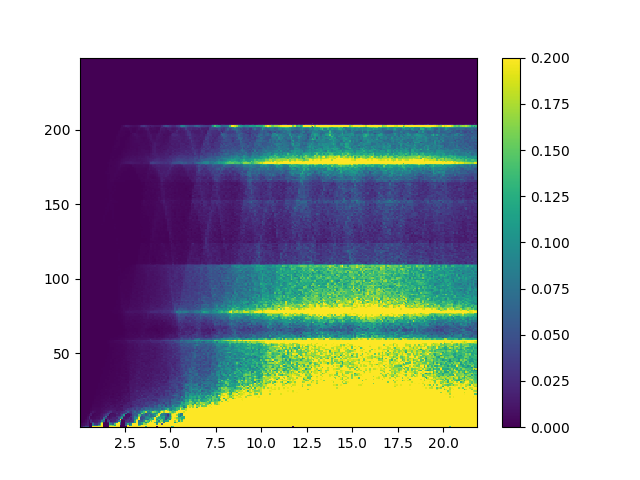

In [393]:
plt.figure()
plotsqe(IQEhist3)
plt.clim(0, .2)

# Normalize

first let us normalize by "event count", and make it density instead of counts

In [394]:
IQEhist4 = IQEhist3.copy()

In [256]:
dQ = Q[1] - Q[0]
dE = E[1] - E[0]

In [400]:
IQEhist4.I /= N
IQEhist4.I /= dQ*dE

Simulate "Vanadium" data

In [164]:
ki

12.032419992662861

In [170]:
cos_theta = np.random.random(N) * 2 - 1
sin_theta = np.sqrt(1-cos_theta*cos_theta)
theta = np.arctan2(sin_theta, cos_theta)

In [172]:
van_Q = ki * np.sin(theta/2.) * 2

In [174]:
%%time
I_norm, Qbb_norm = np.histogram(van_Q, bins=Qbb)

CPU times: user 116 ms, sys: 4 ms, total: 120 ms
Wall time: 119 ms


In [245]:
%matplotlib notebook

<IPython.core.display.Javascript object>


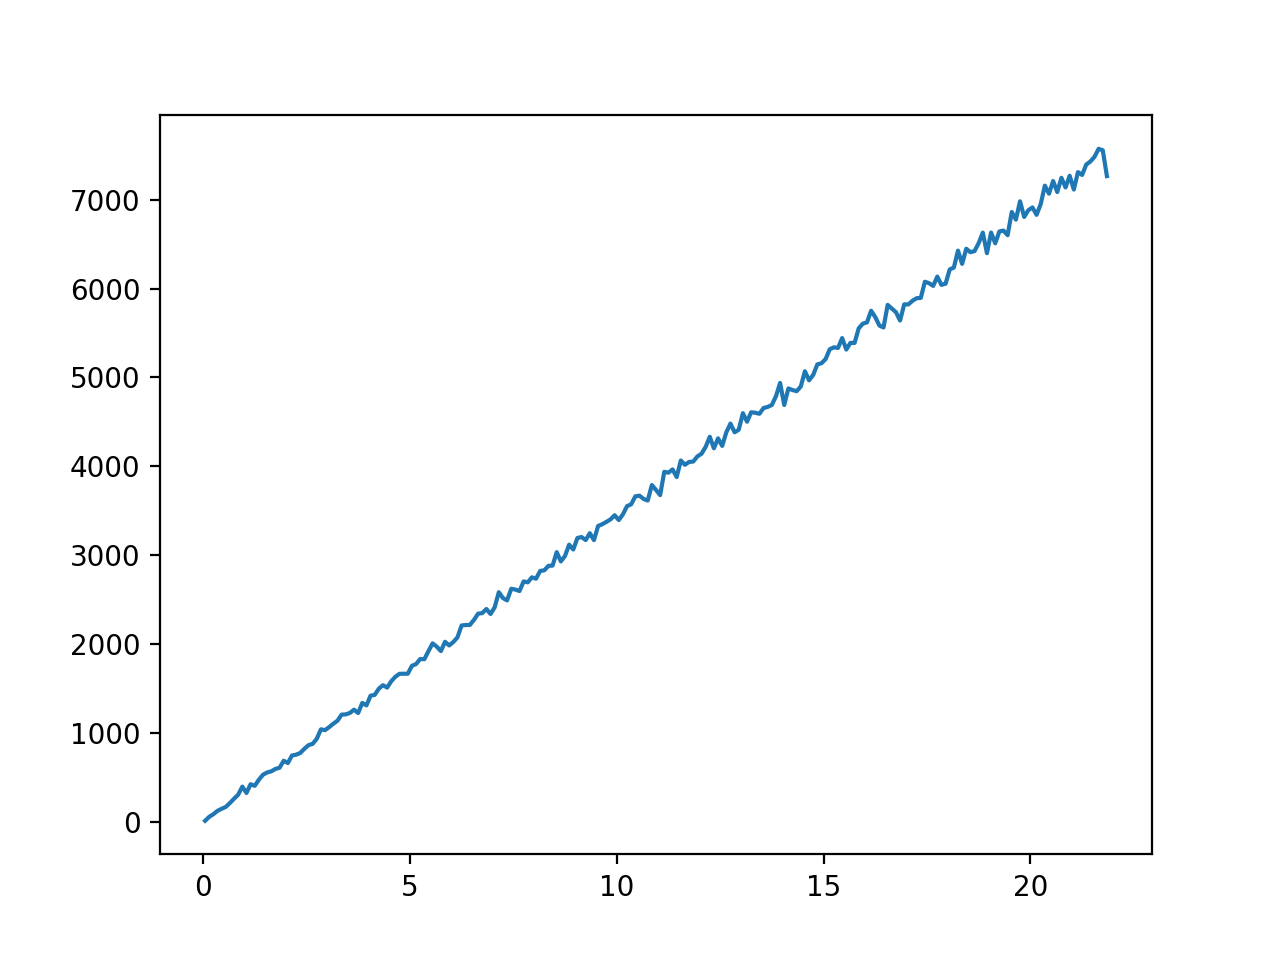

In [246]:
plt.figure()
plt.plot(Q, I_norm)

Apparantly a linear relation

Now try a inelastic case

In [274]:
E1 = 200
Ef1 = Ei - E1
kf1 = conversion.e2k(Ef1)

In [275]:
inel_Q = np.sqrt(ki*ki + kf1*kf1 - 2*ki*kf1*cos_theta)

In [276]:
%%time
I_norm_inel, Qbb_norm_inel = np.histogram(inel_Q, bins=Qbb)

CPU times: user 128 ms, sys: 0 ns, total: 128 ms
Wall time: 129 ms


In [284]:
I_norm_inel = I_norm_inel / (N * dQ)

<IPython.core.display.Javascript object>


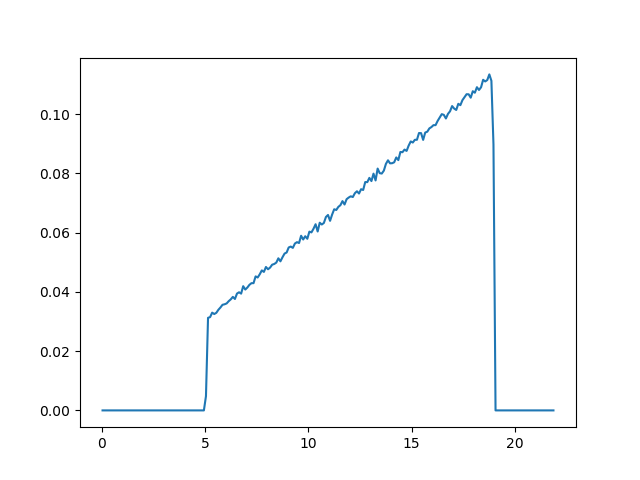

In [285]:
plt.figure()
plt.plot(Q, I_norm_inel)

In [278]:
I_norm_inel.sum()

1000000

All linear

In [287]:
def norm_at(E, Qaxis, Ei):
    "compute normalization(Q) array for the given energy transfer"
    ki = conversion.e2k(Ei)
    Ef = Ei - E
    kf = conversion.e2k(Ef)
    Qmin = np.abs(ki - kf)
    Qmax = ki + kf
    Qmiddle = (Qmin + Qmax)/2
    v_middle = 1./(Qmax-Qmin)
    slope = v_middle / Qmiddle
    rt = np.zeros(Qaxis.shape)
    in_range = (Qaxis<Qmax) * (Qaxis>Qmin)
    rt[in_range] = (Qaxis * slope)[in_range]
    return rt

<IPython.core.display.Javascript object>


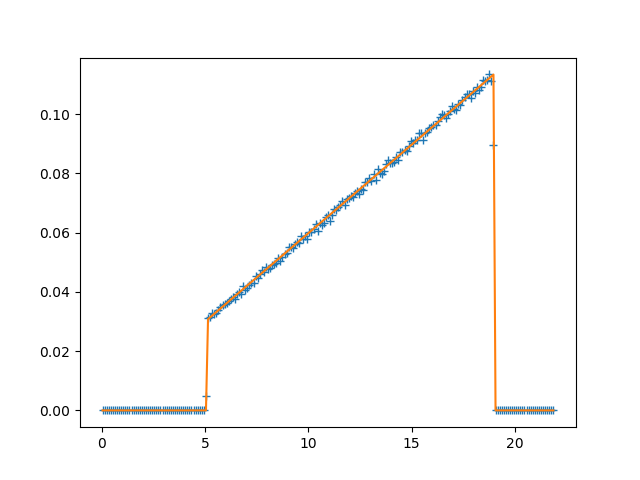

In [288]:
plt.figure()
plt.plot(Q, I_norm_inel, '+')
plt.plot(Q, norm_at(E1, Q, Ei))

In [289]:
norm_hist = IQEhist.copy()
norm_hist.I[:] = 0
for E_ in norm_hist.E:
    norm_hist[(), E_].I[:] = norm_at(E_, Q, Ei)

<IPython.core.display.Javascript object>


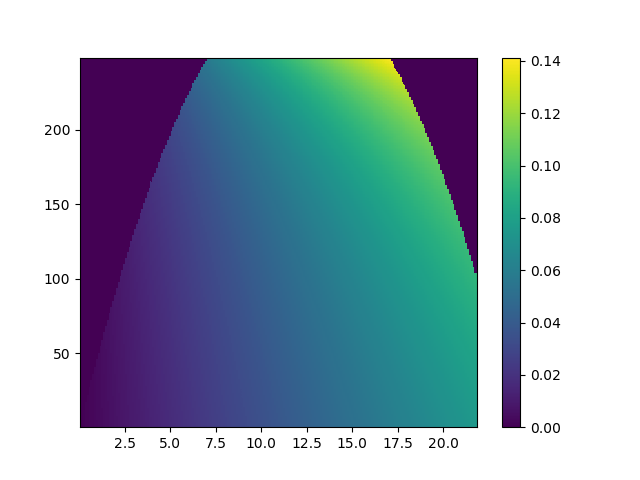

In [399]:
plt.figure()
plotsqe(norm_hist)

In [395]:
IQEhist4 = IQEhist4/norm_hist

<IPython.core.display.Javascript object>


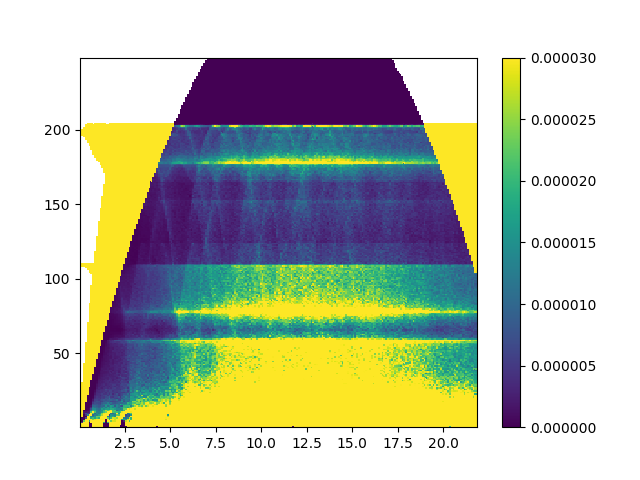

In [403]:
plt.figure()
plotsqe(IQEhist4)
plt.clim(0, 3e-5)

# Dynamical range

In [411]:
Qmin = ki-kf
Qmax = ((ki*ki + kf*kf - 2*ki*kf*np.cos(135.*np.pi/180)))**.5

In [412]:
I4 = IQEhist4.I
for iE, (E1, Qmin1, Qmax1) in enumerate(zip(E, Qmin, Qmax)):
    I4[Q<Qmin1, iE] = np.nan
    I4[Q>Qmax1, iE] = np.nan

<IPython.core.display.Javascript object>


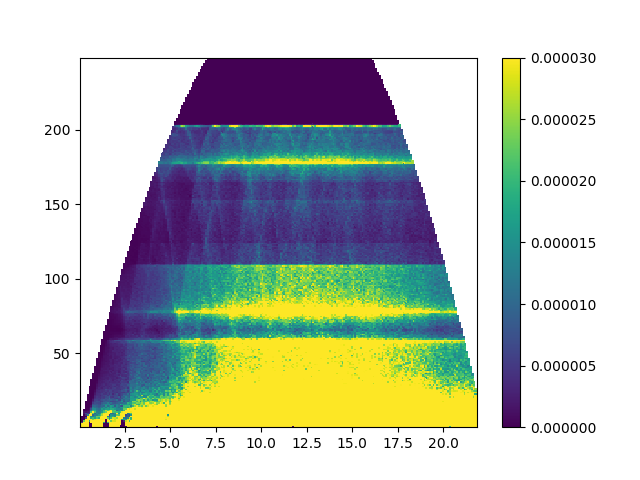

In [413]:
plt.figure()
plotsqe(IQEhist4)
plt.clim(0, 3e-5)

In [414]:
mpsqe = phonon.sqehist(e, g/np.sum(g), Qmin=0.05, Qmax=21.9, dQ=0.1, T=300., M=12, N=5, starting_order=2, Emax=600)

<IPython.core.display.Javascript object>


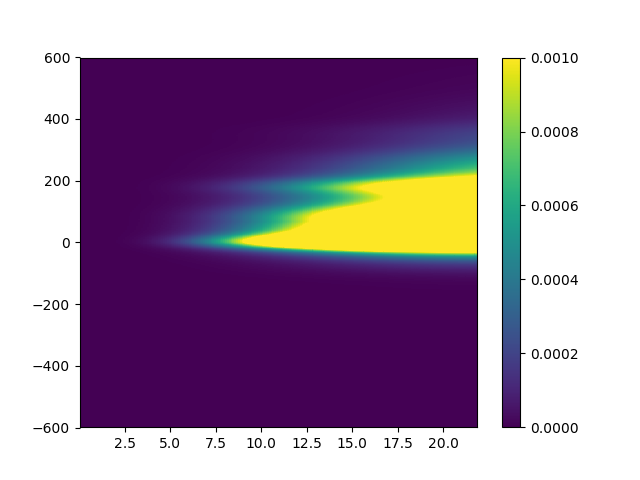

In [416]:
plt.figure()
plotsqe(mpsqe)
plt.clim(0,0.001)

In [418]:
from multiphonon import sqe

In [419]:
mpsqe1 = sqe.interp(mpsqe, E)

<IPython.core.display.Javascript object>


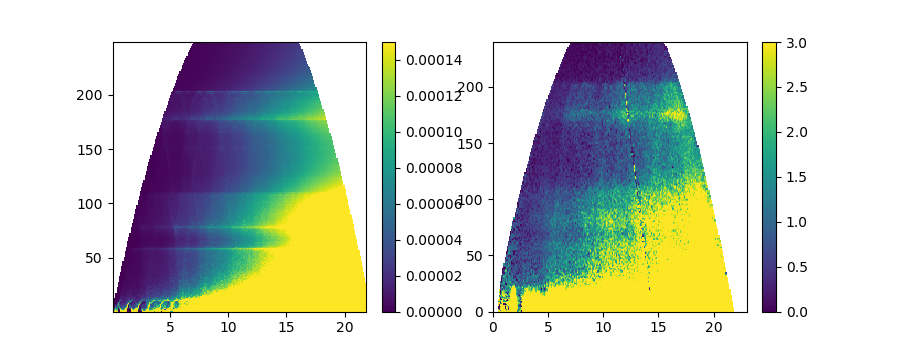

In [438]:
plt.figure(figsize=(9,3.5))
plt.subplot(1,2,1)
plotsqe(IQEhist4*(4*np.pi,0) + mpsqe1)
plt.clim(0,1.5e-4)
plt.subplot(1,2,2)
plotsqe(exp[(), (0, 240)])
plt.clim(0, 3)